In [5]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [6]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [7]:
# general settings for signal and noise
length = 0.5  # in s
noise_power = 10.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   -3,    0,    3,    5,    7,   10, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3,    0, -100,    0,    5,    0, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   10,    5,    0,   -5,   -7,  -10,  -13, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,   10,   10,   10, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# # plot the matrix
# plt.figure(figsize=(6, 3))
# plt.imshow(mat, aspect='auto')
# plt.xlabel(r'Time [Step]')
# plt.ylabel(r'Band')
# cbar = plt.colorbar()
# cbar.set_label(r'Power [dB]')
# plt.savefig('out/wideband_mat.pdf')

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 50000 samples per step.
Signal power: 8.87 dB
Noise power:  10.01 dB
SNR:          -1.14 dB
Num samples:  500000 


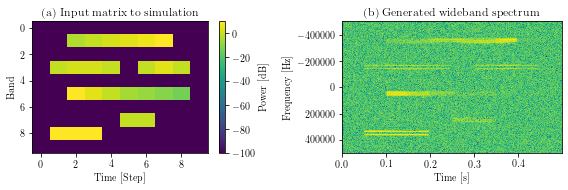

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.75))

img = axs[0].imshow(mat, aspect='auto')
axs[0].set_xlabel(r'Time [Step]')
axs[0].set_ylabel(r'Band')
axs[0].set_title(r'(a) Input matrix to simulation')
cbar = plt.colorbar(img, ax=axs[0])
cbar.set_label(r'Power [dB]')

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)
axs[1].pcolormesh(t,
               f,
               x,
               cmap='viridis',
               vmin=np.min(x),
               vmax=np.max(x))
axs[1].set_xlabel(r'Time [s]')
axs[1].set_ylabel(r'Frequency [Hz]')
axs[1].set_title(r'(b) Generated wideband spectrum')
axs[1].invert_yaxis()

plt.tight_layout()
plt.savefig('out/chap4/wideband.png', dpi=800)